In [1]:
# ref.: 
# - modelling inspired by https://keras.io/examples/vision/swin_transformers/
# - data preprocessing and brief EDA inspired by https://www.kaggle.com/code/tiletisaitejareddy/malware-classification-ism

#setup
import sys
import os
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:
# prepare the data

train_root_path = "./malimg_dataset/train"
val_root_path = "./malimg_dataset/validation"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=train_root_path, target_size=(64,64), batch_size=10000)

Found 8404 images belonging to 25 classes.


In [3]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [4]:
imgs, labels = next(batches)
imgs.shape

(8404, 64, 64, 3)

In [5]:
labels.shape

(8404, 25)

In [6]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

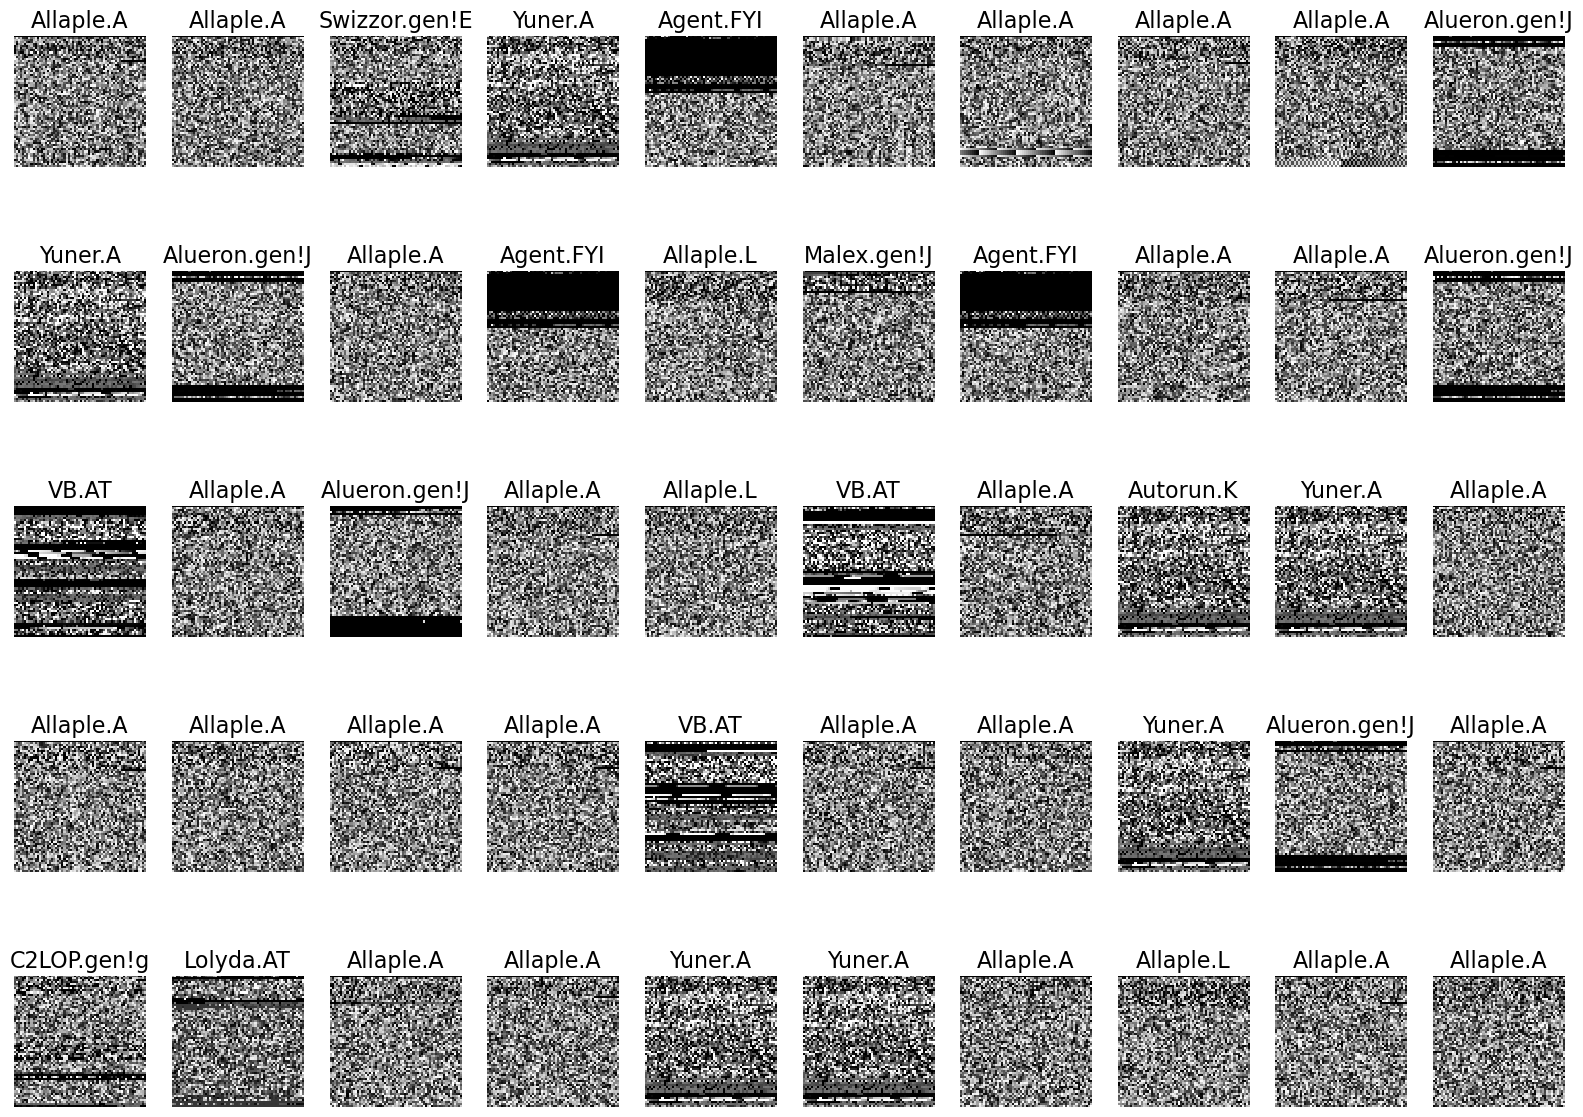

In [7]:
plots(imgs, titles = labels)

<BarContainer object of 25 artists>

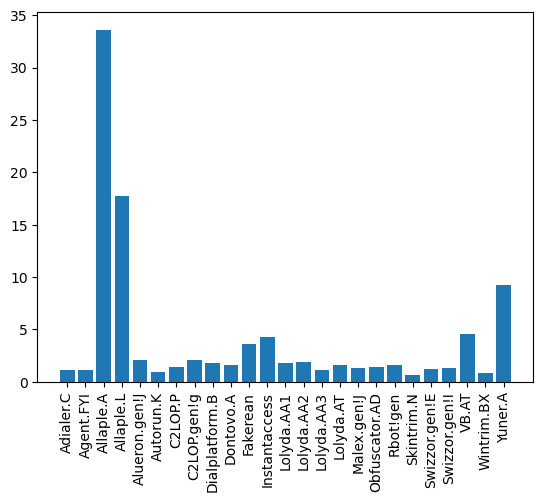

In [8]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

plt.xticks(rotation='vertical')
plt.bar(classes,perc)

Normalize the images, and convert the integer labels to one-hot encoded vectors.

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [10]:
x_train.shape

(5882, 64, 64, 3)

In [11]:
x_test.shape

(2522, 64, 64, 3)

In [12]:
y_train.shape

(5882, 25)

In [13]:
y_test.shape

(2522, 25)

In [14]:
num_classes = len(classes)
# we do not need to apply one-hot encoding to the labels as in https://keras.io/examples/vision/swin_transformers/
# since the dataset data is already prepared for the multi-class classification
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (5882, 64, 64, 3) - y_train shape: (5882, 25)
x_test shape: (2522, 64, 64, 3) - y_test shape: (2522, 25)


# Configure the image input shape

As specified in https://www.kaggle.com/code/tiletisaitejareddy/malware-classification-ism

In [15]:
input_shape=(64,64,3)  # (64,64,3) 

# Configure the hyperparameters
A key parameter to pick is the patch_size, the size of the input patches. In order to use each pixel as an individual input, 
you can set patch_size to (1, 1). Below, we take inspiration from the original paper settings for training on ImageNet-1K, 
keeping most of the original settings for this solution.

**Note:** inspired by https://keras.io/examples/vision/swin_transformers/

In [16]:
patch_size = (2, 2)  # 2-by-2 sized patches 
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 64  # Initial image size - dictated by our dataset specifics

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40 ## TBD - to increase?
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

# Helper functions
We create two helper functions to help us get a sequence of patches from the image, merge patches, and apply dropout.

In [17]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob
        
        #self.add_weight(name='drop_path')

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

# Window based multi-head self-attention
Usually Transformers perform global self-attention, where the relationships between a token and all other tokens are computed. The global computation leads to quadratic complexity with respect to the number of tokens. Here, as the original paper(https://arxiv.org/abs/2103.14030) suggests, we compute self-attention within local windows, in a non-overlapping manner. Global self-attention leads to quadratic computational complexity in the number of patches, whereas window-based self-attention leads to linear complexity and is easily scalable.

In [18]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)
        
        #self.add_weight(name='window_attention')

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
            name='window_attention',
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

# The complete Swin Transformer model
Finally, we put together the complete Swin Transformer by replacing the standard multi-head attention (MHA) with shifted windows attention. As suggested in the original paper, we create a model comprising of a shifted window-based MHA layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying LayerNormalization before each MSA layer and each MLP, and a residual connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and 2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is quite standard in the literature. However in this paper the authors use a 2-layer MLP with GELU nonlinearity in between.

In [19]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

# Model training and evaluation
## Extract and embed patches
We first create 3 layers to help us extract, embed and merge patches from the images on top of which we will later use the Swin Transformer class we built.

In [20]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]
        
        #self.add_weight(name='patch_extract')

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)
        
        #self.add_weight(name='patch_embedding')

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)
        
        #self.add_weight(name='patch_merging')

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

## Build the model
We put together the Swin Transformer model.

In [21]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

## Train the model

In [22]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 random_crop (RandomCrop)    (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 patch_extract (PatchExtract  (None, 1024, 12)         0         
 )                                                               
                                                                 
 patch_embedding (PatchEmbed  (None, 1024, 64)         66368     
 ding)                                                           
                                                                 
 swin_transformer (SwinTrans  (None, 1024, 64)         50072 

Start the model training

In [23]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

model_fit = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
    verbose =1,
    callbacks=[early_stop,lr_reduction]
)

Epoch 1/40
42/42 [==============================] - 182s 4s/step - loss: 2.1967 - accuracy: 0.4253 - top-5-accuracy: 0.7756 - val_loss: 1.7290 - val_accuracy: 0.5705 - val_top-5-accuracy: 0.8964 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - 178s 4s/step - loss: 1.5917 - accuracy: 0.6410 - top-5-accuracy: 0.9220 - val_loss: 1.4164 - val_accuracy: 0.7250 - val_top-5-accuracy: 0.9474 - lr: 0.0010
Epoch 3/40
42/42 [==============================] - 183s 4s/step - loss: 1.3649 - accuracy: 0.7491 - top-5-accuracy: 0.9607 - val_loss: 1.2783 - val_accuracy: 0.7980 - val_top-5-accuracy: 0.9762 - lr: 0.0010
Epoch 4/40
42/42 [==============================] - 177s 4s/step - loss: 1.2151 - accuracy: 0.8133 - top-5-accuracy: 0.9788 - val_loss: 1.1119 - val_accuracy: 0.8761 - val_top-5-accuracy: 0.9915 - lr: 0.0010
Epoch 5/40
42/42 [==============================] - 179s 4s/step - loss: 1.0811 - accuracy: 0.8795 - top-5-accuracy: 0.9839 - val_loss: 1.0096 - val_accuracy: 0.8913 - 

In [24]:
model.evaluate(x_test,  y_test)

79/79 [==============================] - 26s 324ms/step - loss: 0.7732 - accuracy: 0.9611 - top-5-accuracy: 0.9972


[0.7731767296791077, 0.9611419439315796, 0.9972244501113892]

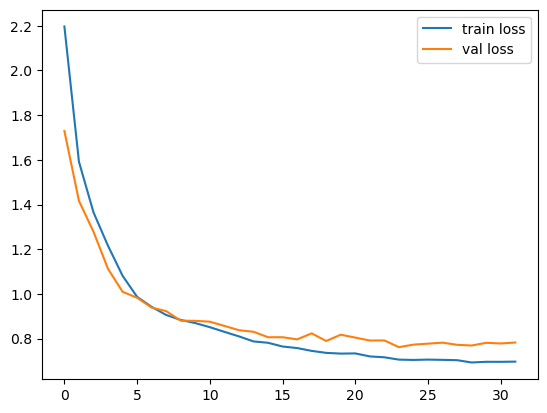

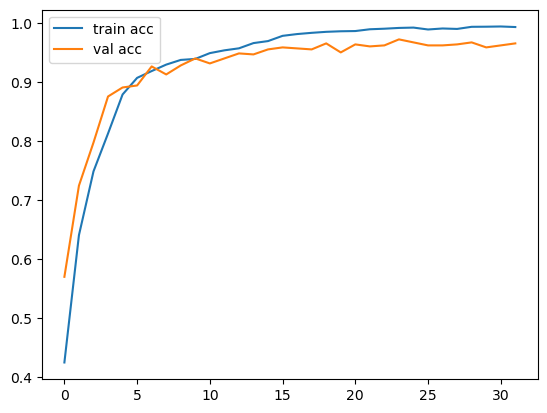

In [25]:
# plot the loss
plt.plot(model_fit.history['loss'], label='train loss')
plt.plot(model_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Swin_LossVal_loss.jpg',format='jpg')

plt.close()
# plot the accuracy
plt.plot(model_fit.history['accuracy'], label='train acc')
plt.plot(model_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Swin_AccVal_acc.jpg',format="jpg")

plt.close()

# Make Predictions

In [27]:
pred_x = model.predict(x_test, verbose=0) 
y_pred=np.argmax(pred_x,axis=1)
y_pred

array([ 2,  2,  2, ...,  2, 24,  2], dtype=int64)

In [28]:
y_test2 = np.argmax(y_test, axis=1)
y_test2

array([ 2,  2,  2, ...,  2, 24,  2], dtype=int64)

In [29]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [30]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

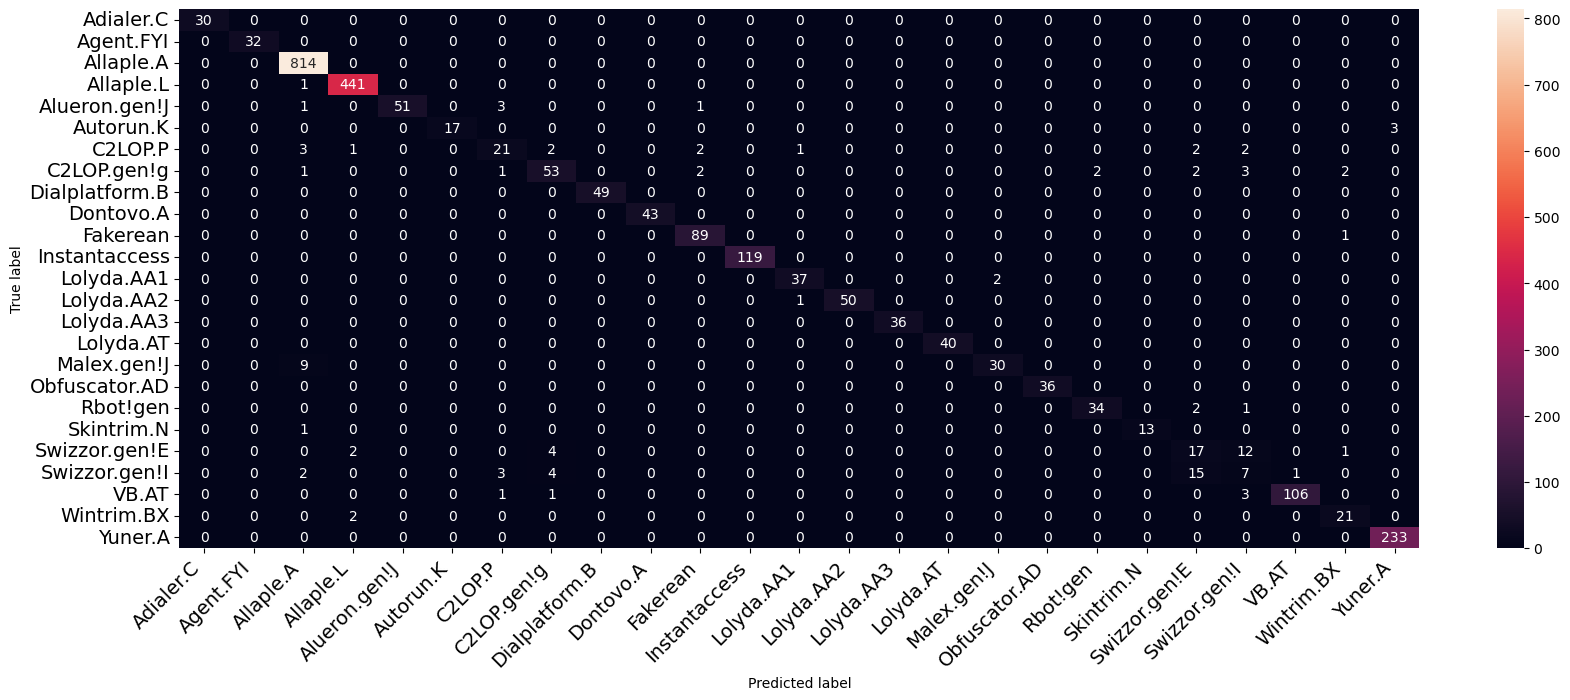

In [31]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

In [32]:
from sklearn import metrics
# Print the precision and recall, among other metrics
report =  metrics.classification_report(y_test2, y_pred, digits=3, output_dict=True)

df = pd.DataFrame(report).transpose().reset_index()
df = df.rename(columns={"index": "class_label"})

Let's review the part of the classification report related to each individual class

In [33]:
clf_rep = metrics.precision_recall_fscore_support(y_test2, y_pred)
out_dict = {
             "precision" : clf_rep[0].round(3)
            ,"recall" : clf_rep[1].round(3)
            ,"f1-score" : clf_rep[2].round(3)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict).reset_index().rename(columns={"index": "class_label"})
class_label_values = dict(zip(range(0,len(batches.class_indices)), batches.class_indices))
out_df['class_label'] = out_df['class_label'].map(class_label_values)
out_df

,class_label,precision,recall,f1-score,support
0,Adialer.C,1.000,1.000,1.000,30
1,Agent.FYI,1.000,1.000,1.000,32
2,Allaple.A,0.978,1.000,0.989,814
3,Allaple.L,0.989,0.998,0.993,442
4,Alueron.gen!J,1.000,0.911,0.953,56
5,Autorun.K,1.000,0.850,0.919,20
6,C2LOP.P,0.724,0.618,0.667,34
7,C2LOP.gen!g,0.828,0.803,0.815,66
8,Dialplatform.B,1.000,1.000,1.000,49
9,Dontovo.A,1.000,1.000,1.000,43


Now let's review the aggregated values from  the classification report

In [34]:
# display aggregated values - selecting rows based on condition 
options = ['accuracy', 'macro avg',  'weighted avg']
agg_df = df[df['class_label'].isin(options)]
agg_df

,class_label,precision,recall,f1-score,support
25,accuracy,0.959159,0.959159,0.959159,0.959159
26,macro avg,0.912488,0.890913,0.900647,2522.000000
27,weighted avg,0.957913,0.959159,0.958131,2522.000000
